In [17]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import integrate
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
mp_key = "VGJDyi0TH2uezP850Utn6gEwHnI5i365"
mp_id = "mp-961713" #ZrSnPt
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Calcul des températures de Debye et d'Einstein 

In [8]:
temperatures = np.arange(1, 1000, 1)
R = 8.314
N_atome = len(prim_struc)
Cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))]) / (3 * N_atome * R)

### Température d'Einstein
La formule pour la chaleur spécifique $ C_v $ à une température $ T $ dans le modèle d'Einstein, incluant $ N_{\text{at}} $ d'atomes, est :

$$
C_v = 3R N_{\text{at}} \left( \frac{\theta_E}{T} \right)^2 \frac{e^{\frac{\theta_E}{T}}}{(e^{\frac{\theta_E}{T}} - 1)^2}
$$

La relation entre la température d'Einstein $ \theta_E $ et la fréquence d'Einstein $ \omega_E $ est la suivante :
$$
\theta_E = \frac{\hbar \omega_E}{k_B}
$$
où :

- $ \hbar $ est la constante de Planck réduite,
- $ \omega_E $ est la fréquence d'Einstein,
- $ k_B $ est la constante de Boltzmann.

À haute température ( $ T \gg \theta_E $ ), la chaleur spécifique $ C_v $ tend vers $ 3N_{\text{at}}R $     
À basse température ( $ T \ll \theta_E $ ), la chaleur spécifique $ C_v $ tend vers $ \exp\left(-\frac{\theta_E}{T}\right) $

Le modèle d'Einstein fait l'hypothèse que toutes les fréquences  $ \omega_\sigma(q) $ sont égales à une fréquence naturelle de vibration $ \omega_E $



In [18]:
T_E_opti = 1
mse_E_opti = float('inf')

def einstein_model(T_e, T):
    return ((T_e / T)**2) * np.exp(T_e / T) / ((np.exp(T_e / T) - 1) ** 2)

for t in range(1, 1000):  # Range de température ppur trouver l'opti
    mse_tot = 0
    for i in temperatures[:-1]: # On parcourt temperatures
        cv_pred = einstein_model(t, temperatures[i])
        # Calcul de l'erreur pour cette prédiction
        mse_tot += (cv_pred - Cv[i])**2
    # Mise à jour de la température d'Einstein optimale si une erreur inférieure est trouvée
    if mse_tot < mse_E_opti:
        mse_E_opti = mse_tot
        T_E_opti = t

print("MSE minimale d'Einstein :", mse_E_opti)
print("Température optimale d'Einstein :", T_E_opti,"K")

Cv_einstein = np.array([einstein_model(T_E_opti, T) for T in temperatures])

MSE minimale d'Einstein : 0.1381633929242876
Température optimale d'Einstein : 212 K


### Température de Debye

La formule pour la chaleur spécifique $ C_v $ à une température $ T $ dans le modèle de Debye, incluant $ N_{\text{at}} $ d'atomes, est :
$$
C_v = 9 N_{\text{at}} R \left( \frac{T}{\theta_D} \right)^3 \int_0^{\frac{\theta_D}{T}} \frac{x^4 e^x}{(e^x - 1)^2} dx
$$

La relation entre la température de Debye $ \theta_D $ et la fréquence de Debye $ \omega_D $ est la suivante :
$$
\theta_D = \frac{\hbar \omega_D}{k_B}
$$
où :

- $ \hbar $ est la constante de Planck réduite,
- $ \omega_D $ est la fréquence de Debye,
- $ k_B $ est la constante de Boltzmann.

À haute température ( $ T \gg \theta_D $ ), la chaleur spécifique $ C_v $ tend vers $ 3N_{\text{at}}R $     
À basse température ( $ T \ll \theta_D $ ), la chaleur spécifique $ C_v $ tend vers $ T^3 $

Le modèle de Debye fait l’hypothèse que toutes les fréquences $ \omega_\sigma(q) $ ont la même dispersion linéaire : $ \omega_\sigma(q) = vq $. De plus, l’intégrale sur la première zone de Brillouin est remplacée par une intégrale sur une sphère de rayon $ q_D $, choisi de telle sorte que la sphère contienne $ N_{\text{cell}} $ vecteurs d’onde $ q $ permis.  
Ces hypothèses font que le modèle de Debye approxime mieux les données expérimentales que le modèle d’Einstein.



In [19]:
T_D_opti = 1
mse_D_opti = float('inf')

def debye_model(T_d, T):
    return 3 * ((T / T_d)**3) * integrate.quad(lambda x: (x**4) * np.exp(x) / ((np.exp(x) - 1)**2), 0, T_d / T)[0]

for t in range(1, 1000):  # Range de température ppur trouver l'opti
    mse_tot = 0
    for i in temperatures[:-1]: # On parcourt temperatures
        cv_pred = debye_model(t, temperatures[i])
        # Calcul de l'erreur pour cette prédiction
        mse_tot += (cv_pred - Cv[i])**2
    # Mise à jour de la température d'Einstein optimale si une erreur inférieure est trouvée
    if mse_tot < mse_D_opti:
        mse_D_opti = mse_tot
        T_D_opti = t

print("MSE minimale de Debye :", mse_D_opti)
print("Température optimale de Debye :", T_D_opti, "K")

Cv_debye = np.array([debye_model(T_D_opti, T) for T in temperatures])

MSE minimale de Debye : 0.015283308136691947
Température optimale de Debye : 287 K


# Représentation des courbes de chaleur spécifique

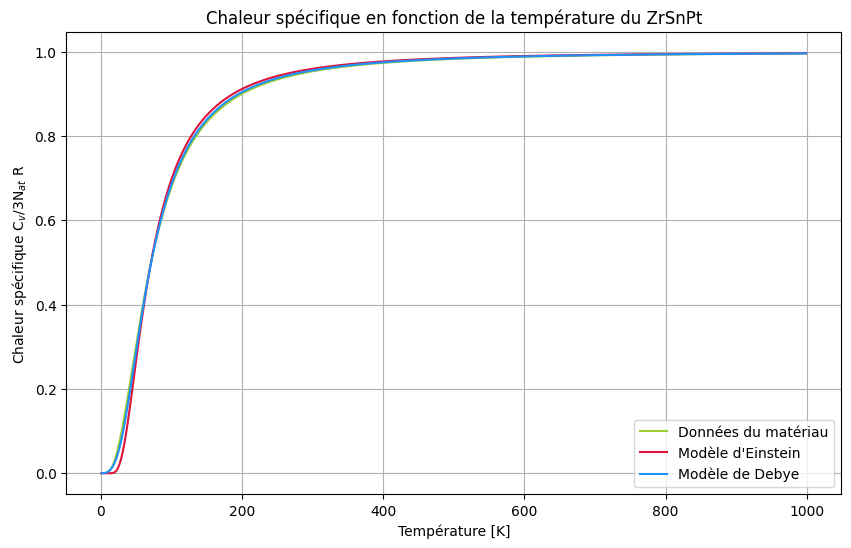

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, Cv, label='Données du matériau', color='yellowgreen')
plt.plot(temperatures, Cv_einstein, label='Modèle d\'Einstein', color='crimson')
plt.plot(temperatures, Cv_debye, label='Modèle de Debye', color='dodgerblue')
plt.title('Chaleur spécifique en fonction de la température du ZrSnPt')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique C$_{v}$/3N$_{at}$ R')
plt.legend()
plt.grid(True)
plt.show()

# Représentation des densités d'états de phonons

La densité de modes normaux par cellule unité $ g(\omega) $ est définie de telle sorte que $ g(\omega) \, d\omega $ est le nombre total de modes normaux dont la fréquence est comprise entre $ \omega $ et $ \omega + d\omega $ divisé par le volume de la cellule unité.

La densité de modes normaux peut s’écrire :

$$
g(\omega) = \frac{1}{N_{\text{cell}}} \sum_\delta \int \frac{1}{(2\pi)^3} \delta(\omega - \omega_\delta(q)) V \, dq
$$

ou encore :

$$
g(\omega) = \frac{\Omega}{(2\pi)^3} \sum_\delta \int \delta(\omega - \omega_\delta(q)) \, dq
$$

La densité de modes normaux, qui est aussi la densité d’états des phonons, est normalisée de telle sorte que:
$ g(\omega) \, d\omega = 3N_{\text{at}} $

#### Modèle d'Einstein

$ g(\omega) $ est un delta de Dirac piqué en $ \omega_E $ :   
$ g_E(w) = 3N_{\text{at}} \delta(w - w_E) $

#### Modèle de Debye 

$ g(\omega) $ est une fonction parabolique de la fréquence :    
$ g_D(\omega) = \frac{3N_{\text{at}}\Omega}{(2\pi)^3} \int_{q<q_D} \delta(\omega - vq) \, dq $
$= \frac{3N_{\text{at}}\Omega}{2\pi^2} \int_{0}^{q_D} \delta(\omega - vq)q^2 \, dq $   
$ g_D(\omega) = \begin{cases} \frac{3N_{\text{at}}\Omega}{2\pi^2} \frac{\omega^2}{v^3} & \text{pour } \omega < \omega_D = vq_D \\ 0 & \text{pour } \omega > \omega_D \end{cases} $

Ce comportement en $\omega^2 $ est une grossière approximation. Cependant, le choix de $ q_D $ garantit que l’aire sous la courbe $ g_D(\omega) $ est la même que celle sous la courbe exacte (l'aire vaut $3N_{\text{at}}$).



La fréquence d'Einstein est : 4.417363252663275 [THz]
La fréquence de Debye est : 5.980109686388491 [THz]


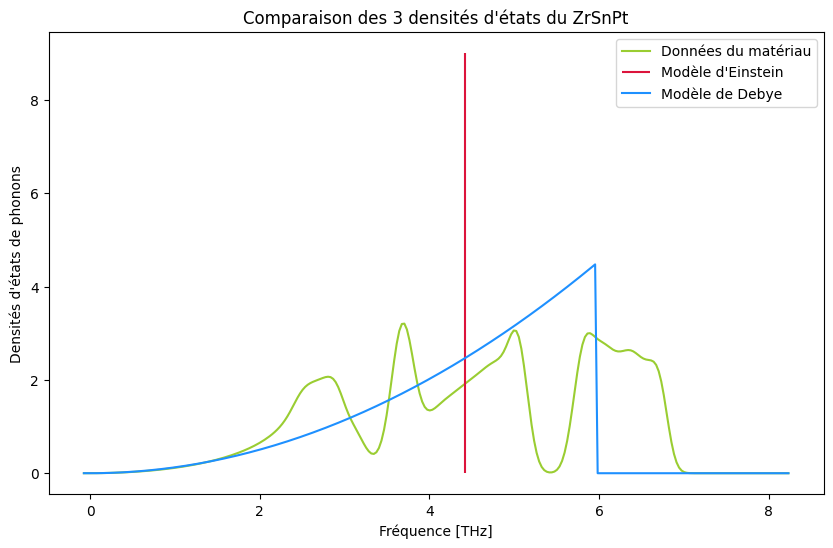

In [15]:
k_b = 1.380649e-23 #constante de Boltzmann
h_barre = 1.054571818e-34 #constante de Planck réduite

#DOS du matériaux
freq  = ph_dos.frequencies 
dens = ph_dos.densities

#DOS du modèle d'Einstein
w_E = 1e-12 * k_b * T_E_opti /h_barre
freq_E = w_E/(2*np.pi) #w = 2 pi f

#DOS du modèle de Debye
w_D = 1e-12 * k_b * T_D_opti /h_barre
freq_D = w_D/(2*np.pi) #w = 2 pi f
dens_D = np.zeros(len(freq))

for i,f in enumerate(freq):
    w = 2*np.pi*f
    if w < w_D:
        dens_D[i] = (9*N_atome*(w)**2/(w_D**3))

print('La fréquence d\'Einstein est :',freq_E, '[THz]')
print('La fréquence de Debye est :',freq_D, '[THz]')
#Plot
plt.figure(figsize=(10, 6))
plt.plot(freq, dens,color = 'yellowgreen', label='Données du matériau')
plt.vlines(freq_E, 0, 3 * N_atome ,color ='crimson', label = 'Modèle d\'Einstein')
plt.plot(freq, dens_D*(2*np.pi), color='dodgerblue', label='Modèle de Debye')
plt.title('Comparaison des 3 densités d\'états du ZrSnPt')
plt.ylabel('Densités d\'états de phonons')
plt.xlabel('Fréquence [THz]')
plt.legend()
plt.show()